# Introduction
We have been provided with data of one of the largest food chain restaurant in US. Data includes data about transaction of ingredients purchased, ingredients names, ingredients measurement unit, recipe names, sub recipes, store details, etc. Data has been provided for time period Early March - 2015 to Mid June - 2015. 

Our main objective of this assignment is to try various combination of holt-winters and ARIMA models and predict trend for next 2 weeks starting from 15-6-2015 till 29-6-2015.

We'll be using statsmodels library for model purpose as it provides implementation of ARIMA and holt-winters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error

from IPython.display import FileLink

import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Loading Datasets

### Measurement Unit Type Dataset

In [2]:
root_dir = '/kaggle/input/demand-forecasting-for-a-fast-food-restaurant/data/data/'

portion_uom_types = pd.read_csv(os.path.join(root_dir, 'portion_uom_types.csv'))
print('Portion UOM Types : ', portion_uom_types.shape)
portion_uom_types.head()

Portion UOM Types :  (5, 2)


,PortionTypeDescription,PortionUOMTypeId
0,Each,11
1,Fluid Ounce,12
2,Gram,13
3,Milliliter,14
4,Ounce,15


### Recipe to Sub-recipe Mappings Dataset

In [3]:
recipe_sub_recipe_assignments = pd.read_csv(os.path.join(root_dir, 'recipe_sub_recipe_assignments.csv'))
print('Recipe Sub Recipe Assignments : ', recipe_sub_recipe_assignments.shape)
recipe_sub_recipe_assignments.head(10)

Recipe Sub Recipe Assignments :  (13890, 3)


,RecipeId,SubRecipeId,Factor
0,2,3,1
1,2,9,1
2,2,10,1
3,2,12,1
4,6,1,1
5,6,9,1
6,6,10,1
7,6,12,1
8,7,9,1
9,7,10,1


### Recipe to Ingredients Mapping Dataset

In [4]:
recipe_ingredient_assignments = pd.read_csv(os.path.join(root_dir, 'recipe_ingredient_assignments.csv'))
print('Recipe Ingredient Assignments : ', recipe_ingredient_assignments.shape)
recipe_ingredient_assignments.head(10)

Recipe Ingredient Assignments :  (14308, 3)


,RecipeId,IngredientId,Quantity
0,2,7,4
1,6,7,4
2,7,7,2
3,8,7,2
4,9,7,2
5,10,13,4
6,11,13,4
7,12,13,2
8,13,13,2
9,14,13,2


### Transactional Menuitems Dataset.
It contains information about daily order of various recipes at various stores with price data.

In [5]:
menuitem = pd.read_csv(os.path.join(root_dir, 'menuitem.csv'), )
menuitem.date = '20' + menuitem.date
menuitem.date = pd.to_datetime(menuitem.date)
print('MenuItem : ', menuitem.shape)
menuitem.head(8)

MenuItem :  (91431, 15)


,MD5KEY_MENUITEM,MD5KEY_ORDERSALE,CategoryDescription,DepartmentDescription,Description,StoreNumber,TaxInclusiveAmount,TaxAmount,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date
0,001E0224E4EDA63D6FED96D59E0C1E76,072D3B76BE58E4553A373AF3206D2CA5,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-05
1,003E4E20196B2F5BDD33CE06D2943EF4,14811D4F3458058007B0B6908C2DA393,Fountain,Fountain Drink 21 oz.,21oz Fountain Drink,46673,0,0.1530,1.70,0.00,1.70,1,212000126,280,2015-03-05
2,012A55E5551C95A559A7B074AE85117E,22FA6C39B7A15ABB6EB568E66A6B30E1,6 Inch,6 Inch Sub,B.M.T. 6 inch,12631,0,0.3230,3.64,0.61,4.25,1,121000008,8,2015-03-05
3,01B07F1C6DC6945796571FC78735DA16,915B69612845BBD974C39AC105F5CA8C,6 Inch,6 Inch Sub,Veggie Delite 6 inch,12631,0,0.3328,3.75,0.00,3.75,1,121000001,91,2015-03-05
4,02DE19974DE5304BF243A1C2EC639495,CD6386C802450EDCF13A3D112D1F86EC,Add On,Add On 6in Portion,Avocado Add6in,12631,0,0.0443,0.50,0.00,0.50,1,175000062,564,2015-03-05
5,03F5700F4CB7F5388F217E1532F9A0C3,2B6FD9058A4A28E5E298C95D3C615B27,6 Inch,6 Inch Sub,Turkey 6 inch,46673,0,0.3519,3.91,1.34,5.25,1,121000012,13,2015-03-05
6,04420CE325EFCE905A9155CBE6EBC001,72BC117B86F77DF24BEB37C0B191B7B1,Footlong,Footlong Sub,Spicy Italian FtLong,12631,0,0.4881,5.50,0.00,5.50,1,111000002,69,2015-03-05
7,0468A23C2C56158FC8F3A0157EE8CEFA,39EEA7FA648C8EAF5CFB4B1EDD18E30F,Bottled Beverage,Bottled Drink,Bottled Carbonated Drink,12631,0,0.1553,1.75,0.00,1.75,1,221000133,279,2015-03-05


### MenuItems Dataset
It contains information about recipes for each store.

In [6]:
menu_items = pd.read_csv(os.path.join(root_dir, 'menu_items.csv'))
print('Menu Items : ',menu_items.shape)
menu_items.head()

Menu Items :  (8005, 5)


,MenuItemName,MenuItemDescription,PLU,MenuItemId,RecipeId
0,FtL/Ham,Ham FtLong,111000004,1,6
1,Six/Ham,Ham 6 inch,121000004,2,7
2,FfB/Ham,Ham FtFbd,112000004,3,2
3,fBd/Ham,Ham FlatBd,122000004,4,8
4,Sld/Ham,Ham Salad,131000004,5,9


### Pos OrderSale Dataset

In [7]:
pos_ordersale = pd.read_csv(os.path.join(root_dir, 'pos_ordersale.csv'))
print('Post Order Sale : ',pos_ordersale.shape)
pos_ordersale.head(10)

Post Order Sale :  (43228, 9)


,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxInclusiveAmount,TaxAmount,MealLocation,TransactionId,StoreNumber,date
0,00BCB738A1F814DB960C25012E9913DF,0.00,67,0,0.56,0,67,46673,15-03-05
1,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0,0.54,0,39,12631,15-03-05
2,04AEF56CF3130AC1EFAD41C470F5245D,0.00,81,0,0.69,0,79,46673,15-03-05
3,04BBFAD4E73C30EE2EC3B4E52509637C,0.00,159,0,1.16,0,159,12631,15-03-05
4,061AE382DC127057E8ADBBF869CFB361,0.00,51,0,0.00,0,51,12631,15-03-05
5,0653EFBC62931D45E96BFB82040123EA,94.01,83,0,0.49,0,83,12631,15-03-05
6,0683B0A81C854E7BBE3B2CFD3D75D62C,0.00,40,0,0.00,0,40,12631,15-03-05
7,072D3B76BE58E4553A373AF3206D2CA5,0.00,90,0,0.90,0,87,46673,15-03-05
8,07436936F3929B875D3128106550394F,0.00,19,0,0.79,0,19,46673,15-03-05
9,09F16AC6C629944163B1E60A4CF104F0,0.00,7,0,1.16,0,7,12631,15-03-05


### Sub-recipes Dataset

In [8]:
sub_recipes = pd.read_csv(os.path.join(root_dir, 'sub_recipes.csv'))
print('Sub Recipes : ', sub_recipes.shape)
sub_recipes.head()

Sub Recipes :  (81, 3)


,SubRecipeName,SubRecipeDescription,SubRecipeId
0,Std Footlong Sub bread,Std Footlong Sub Bread,1
1,Std 6 Inch Sub bread,Std 6 Inch Sub Bread,2
2,Std Footlong Flatbread Bread,Std Footlong Flatbread Bread,3
3,Std 6 Inch Flatbread bread,Std 6 Inch Flatbread bread,4
4,"Std Salad Lettuce, bowl, & dressing","Std Salad Lettuce, Bowl & Dressing",5


### Sub-recipes to Ingredients Mapping Dataset

In [9]:
sub_recipe_ingr_assignments = pd.read_csv(os.path.join(root_dir, 'sub_recipe_ingr_assignments.csv'))
print('Sub Recipe Ingredients Assignments : ', sub_recipe_ingr_assignments.shape)
sub_recipe_ingr_assignments.head(8)

Sub Recipe Ingredients Assignments :  (379, 3)


,SubRecipeId,IngredientId,Quantity
0,1,1,1
1,1,135,2
2,1,138,1
3,1,146,1
4,1,157,1
5,3,16,1
6,3,135,2
7,3,138,1


### Recipes Dataset

In [10]:
recipes = pd.read_csv(os.path.join(root_dir, 'recipes.csv'))
print('Recipes : ',recipes.shape)
recipes.head()

Recipes :  (7458, 3)


,RecipeName,RecipeDescription,RecipeId
0,FtL/Ham,Ham FtLong,1
1,FfB/Ham,Ham FtFbd,2
2,Six/Ham,Ham 6 inch,3
3,fBd/Ham,Ham FlatBd,4
4,Sld/Ham,Ham Salad,5


### Ingredients Dataset

In [11]:
ingredients = pd.read_csv(os.path.join(root_dir, 'ingredients.csv'))
ingredients.IngredientName = ingredients.IngredientName.str.strip()
print('Ingredients : ',ingredients.shape)
ingredients.head()

Ingredients :  (673, 4)


,IngredientName,IngredientShortDescription,IngredientId,PortionUOMTypeId
0,Bread,Bread Stick 12 inch/30cm,1,11.0
1,Bacon,Bacon,2,11.0
2,Chicken Strips,Chicken Strips,3,15.0
3,Chicken. oven roasted patty,"Chicken, single piece",4,15.0
4,Cold Cut Combo,Cold Cut Combo,5,15.0


### Store Details Dataset

In [12]:
store_restaurant = pd.read_excel(os.path.join(root_dir, 'store_restaurant.xlsx'))
print('Store Restaurant : ', store_restaurant.shape)
store_restaurant.head()

Store Restaurant :  (4, 9)


,STORE_ADDRESS1,STORE_ADDRESS2,DISTRIBUTION_REGION,STORE_STATE,STORE_CITY,STORE_ZIP,STORE_TYPE,STORE_LOYALTY_FLAG,STORE_NUMBER
0,Ninth Street,,Western,California,Berkeley,94710,Traditional,N,46673
1,Shattuck Sq,Shop #6,Western,California,Berkeley,94704,Traditional,Y,4904
2,Myrtle Avenue,,Northeast,New York,Ridgewood,11385,Traditional,Y,12631
3,Whitney Avenue,,Northeast,New York,Elmhurst,11373,Traditional,Y,20974


## Merging Recipes Data With Ingredients
Below we are merging recipes data with ingredients data to get all ingredients used in particular recipe.

In [13]:
recipe_ingreds_merged = recipe_ingredient_assignments.merge(ingredients, on=['IngredientId'])
print('Merged Recipes With Ingreds : ', recipe_ingreds_merged.shape)
recipe_ingreds_merged.head()

Merged Recipes With Ingreds :  (14308, 6)


,RecipeId,IngredientId,Quantity,IngredientName,IngredientShortDescription,PortionUOMTypeId
0,2,7,4,Ham,Ham,15.0
1,6,7,4,Ham,Ham,15.0
2,7,7,2,Ham,Ham,15.0
3,8,7,2,Ham,Ham,15.0
4,9,7,2,Ham,Ham,15.0


## Merging Sub Recipes Data With Ingredients
Below we are merging sub-recipes with ingredients data to get mapping of sub-recipes to all ingredients used in it.

In [14]:
sub_recipe_ingreds_merged = sub_recipe_ingr_assignments.merge(ingredients, on=['IngredientId'])
print('Merged Sub Recipes With Ingreds : ', sub_recipe_ingreds_merged.shape)
sub_recipe_ingreds_merged.head()

Merged Sub Recipes With Ingreds :  (379, 6)


,SubRecipeId,IngredientId,Quantity,IngredientName,IngredientShortDescription,PortionUOMTypeId
0,1,1,1,Bread,Bread Stick 12 inch/30cm,11.0
1,11,1,1,Bread,Bread Stick 12 inch/30cm,11.0
2,13,1,0,Bread,Bread Stick 12 inch/30cm,11.0
3,15,1,1,Bread,Bread Stick 12 inch/30cm,11.0
4,16,1,1,Bread,Bread Stick 12 inch/30cm,11.0


## Recipe ID to Ingredient Quantity Mapping Function
Below we have designed generic function which takes as input ingredient name and returns quantity of that ingredient used in that recipes. If ingredient is not used then it returns 0. It also considers whether ingredient is used in sub-recipe of that recipe as well.

In [15]:
def recipe_to_ingredient_mapping(ingredient='Lettuce'):
    recipe_id_to_ingred_quantity = {}
    recipe_ids = recipes.RecipeId.values
    for recipe_id in recipe_ids:
        quantity = 0
        recipe_ingreds = recipe_ingreds_merged[recipe_ingreds_merged.RecipeId == recipe_id]
        for ingred, qt in zip(recipe_ingreds.IngredientName, recipe_ingreds.Quantity):
            if ingredient in ingred:
                quantity = quantity + qt
        if recipe_id in recipe_sub_recipe_assignments.RecipeId.values:
            recipe_sub = recipe_sub_recipe_assignments[recipe_sub_recipe_assignments.RecipeId == recipe_id]
            for sub_recipe_id, factor in zip(recipe_sub.SubRecipeId, recipe_sub.Factor):
                sub_recipe_ingreds = sub_recipe_ingreds_merged[sub_recipe_ingreds_merged.SubRecipeId == sub_recipe_id]
                for ingred, qt in zip(sub_recipe_ingreds.IngredientName, sub_recipe_ingreds.Quantity):
                    if ingredient in ingred:
                        quantity = quantity + (factor * qt)
                        
        recipe_id_to_ingred_quantity[recipe_id] = quantity
        
    portion_type_id = ingredients[ingredients.IngredientName == ingredient].PortionUOMTypeId.values[0]
    print('Portion OUM Type : ', portion_uom_types[portion_uom_types.PortionUOMTypeId == portion_type_id].PortionTypeDescription.values[0], '\n')
    return recipe_id_to_ingred_quantity        

In [16]:
%%time

recipe_to_ingredient_mapping_dictionary = recipe_to_ingredient_mapping()

Portion OUM Type :  Ounce       

CPU times: user 30.8 s, sys: 28 ms, total: 30.8 s
Wall time: 30.8 s


## Merging Menu Items with Order Transaction Data
Below we are merging transaction data of daily orders at different store with menuitem data to get recipes order in each order as well as quantity of recipe ordered in on dataset.

In [17]:
merged_menu_items = menuitem.merge(menu_items, left_on = ['PLU', 'Id'], right_on = ['PLU', 'MenuItemId'])
print('Merged Menu Items : ', merged_menu_items.shape)
merged_menu_items.head(8)

Merged Menu Items :  (91431, 19)


,MD5KEY_MENUITEM,MD5KEY_ORDERSALE,CategoryDescription,DepartmentDescription,Description,StoreNumber,TaxInclusiveAmount,TaxAmount,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date,MenuItemName,MenuItemDescription,MenuItemId,RecipeId
0,001E0224E4EDA63D6FED96D59E0C1E76,072D3B76BE58E4553A373AF3206D2CA5,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-05,FtL/ChxStr,Chickn Strips FtLong,326,358
1,D61936B47CD77B3E8622AD6A9D018016,7D30F3AD08E3F133DACD14394B9679F3,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-05,FtL/ChxStr,Chickn Strips FtLong,326,358
2,8B728E7E77C84AD7BD6398EBC91BC42C,3B29437B86232470BFE0D0AFFA2E7018,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-08,FtL/ChxStr,Chickn Strips FtLong,326,358
3,74D92F07C4F265FEE511554117B922A8,0027718CE917155B8145BDF9C75FA0D8,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-11,FtL/ChxStr,Chickn Strips FtLong,326,358
4,6F977301E1C2D20851BD80D69E7F454B,AAE0507061D0B42F1E281B3B9D5C3442,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-29,FtL/ChxStr,Chickn Strips FtLong,326,358
5,5D9DED61DCB41159FA24FECF71A6448B,440E78F6DB68C0C4C233ACB7ACCFB21C,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0,0.6975,7.75,0.00,7.75,1,111000041,326,2015-04-01,FtL/ChxStr,Chickn Strips FtLong,326,358
6,06F1F818018B7EBD4840C5EFAE100167,676365512FF68F71329C8960D4ED2AB0,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0,0.6777,7.53,0.22,7.75,1,111000041,326,2015-04-15,FtL/ChxStr,Chickn Strips FtLong,326,358
7,FDDB787163D52DACCC8CF42F1D40FA7B,7864CD690AADD2D82E166EE1185772CE,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0,0.6975,7.75,0.00,7.75,1,111000041,326,2015-04-16,FtL/ChxStr,Chickn Strips FtLong,326,358


## Calculating Lettuce Usage Per Order

In [18]:
merged_menu_items['LettuceQuantity'] = [recipe_to_ingredient_mapping_dictionary[recipe_id] * quantity for recipe_id, quantity in zip(merged_menu_items.RecipeId, merged_menu_items.Quantity)]

## Lettuce Quantity Distribution

In [19]:
print(Counter(merged_menu_items.LettuceQuantity.values))

Counter({0: 48948, 2: 40225, 4: 1037, 6: 781, 5: 346, 10: 34, 8: 30, 12: 7, 24: 5, 16: 3, 40: 3, 20: 3, 18: 3, 36: 1, 150: 1, 14: 1, 15: 1, 90: 1, 30: 1})


## Creating Final Time-Series Dataframe Of Ingredient Usage
Below we are creating final dataframe which takes all entries of store number 46673 and lettuce quantity and group them based on dates to get total usage per date.

In [20]:
final_df = merged_menu_items[merged_menu_items.StoreNumber == 46673][['date', 'LettuceQuantity']].groupby(by='date').sum()
print('Final Dataframe : ', final_df.shape)
final_df.head(10)

Final Dataframe :  (103, 1)


,LettuceQuantity
date,
2015-03-05,152
2015-03-06,100
2015-03-07,54
2015-03-08,199
2015-03-09,166
2015-03-10,143
2015-03-11,162
2015-03-12,116
2015-03-13,136


## Plotting Lettuce Quantity Demand Over Given Period

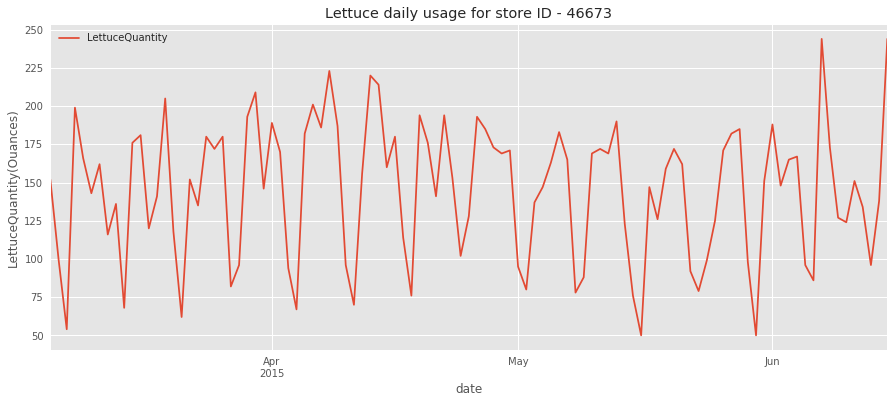

In [21]:
with plt.style.context(('seaborn', 'ggplot')):
    final_df.plot(y='LettuceQuantity', figsize=(15,6))
    plt.ylabel('LettuceQuantity(Ouances)')
    plt.title('Lettuce daily usage for store ID - 46673')

## Plotting ACF
Below we are plotting ACF to get idea about time-series.

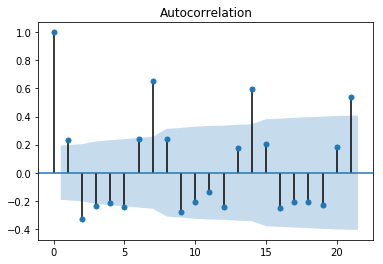

In [22]:
plot_acf(final_df);

## Plotting PACF
Below we are plotting PACF to get idea about time-series trend.

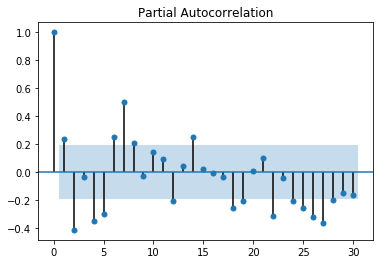

In [23]:
plot_pacf(final_df, lags=30);

# ARIMA Model
Below we'll be trying ARIMA model with various parameter settings to find best one which gives best results.

In [24]:
X = final_df.LettuceQuantity.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

Below method takes train data and calculates MSD error on test data after training model with given parameters as input.

In [25]:
def calculate_error(ar=5, i=1, ma=2):
    history = [x for x in train]
    try:
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=(ar,i,ma))
            model_fit = model.fit(disp=0, maxiter=700)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
        error = mean_squared_error(test, predictions)
    except:
        error,predictions  = None, None
    if error:
        print('Params : %s, Error : %f'%(str([ar,i,ma]), error))
    return error, predictions

## Grid Search Parameters to find best settings

In [26]:
least_error = 10000
ar_vals = [0, 1, 2, 3, 4, 5, 6, 7,]
i_vals = [0, 1, 2]
ma_vals = [0, 1, 2, 3]
best_params = None
best_preds = None
for ar in ar_vals:
    for i in i_vals:
        for ma in ma_vals:
            error, predictions = calculate_error(ar, i, ma)
            if error and error < least_error:
                least_error = error
                best_params = [ar, i, ma]
                best_preds = predictions
                print('Best Params : %s, Least Error : %f'%(str([ar,i,ma]), least_error))


Params : [0, 0, 1], Error : 1780.706078
Best Params : [0, 0, 1], Least Error : 1780.706078
Params : [0, 0, 2], Error : 1856.906614
Params : [0, 0, 3], Error : 1628.884477
Best Params : [0, 0, 3], Least Error : 1628.884477
Params : [0, 1, 1], Error : 2259.628805
Params : [0, 1, 2], Error : 1846.290258
Params : [0, 1, 3], Error : 2098.987349
Params : [0, 2, 1], Error : 2998.338929
Params : [1, 0, 0], Error : 2017.723679
Params : [1, 0, 1], Error : 1826.820317
Params : [1, 0, 2], Error : 1730.581605
Params : [1, 0, 3], Error : 1636.462912
Params : [1, 1, 0], Error : 2946.462292
Params : [1, 2, 0], Error : 5361.768912
Params : [2, 0, 0], Error : 1661.206961
Params : [2, 0, 1], Error : 1675.676728
Params : [2, 1, 0], Error : 2457.133516
Params : [2, 1, 2], Error : 1724.115875
Params : [2, 2, 0], Error : 4107.997033
Params : [2, 2, 2], Error : 2122.042977
Params : [3, 0, 0], Error : 1668.082580
Params : [3, 0, 1], Error : 1673.291286
Params : [3, 0, 2], Error : 1662.409982
Params : [3, 0, 3]

In [27]:
print('\nBest Parameter Settings : AR : %d, I : %d, MA : %d'%tuple(best_params))


Best Parameter Settings : AR : 6, I : 0, MA : 1


In [28]:
history = [x for x in X]
model = ARIMA(history, order=(best_params[0], best_params[1], best_params[2]))
model_fit = model.fit(disp=0, maxiter=700)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  103
Model:                     ARMA(6, 1)   Log Likelihood                -501.649
Method:                       css-mle   S.D. of innovations             31.061
Date:                Sun, 27 Oct 2019   AIC                           1021.298
Time:                        07:54:17   BIC                           1045.010
Sample:                             0   HQIC                          1030.902
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.7847      4.852     29.842      0.000     135.276     154.294
ar.L1.y        0.8677      0.102      8.515      0.000       0.668       1.067
ar.L2.y       -0.5516      0.121     -4.559      0.0

## Predicting Next 2 weeks using Best Param Settings

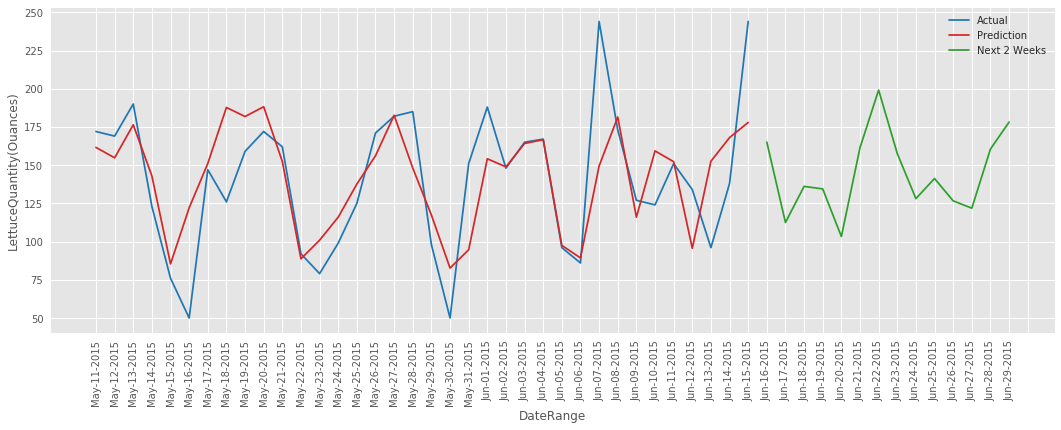

In [29]:
new_two_weeks_preds = []
history = [x for x in X]

for t in range(14):
    model = ARIMA(history, order=(best_params[0], best_params[1], best_params[2])) ## Add Best Params Here
    model_fit = model.fit(disp=0, maxiter=700)
    output = model_fit.forecast()
    yhat = output[0]
    new_two_weeks_preds.append(yhat[0])
    history.append(yhat[0])
    
ticks = pd.date_range(final_df.index[size:len(X)][0], final_df.index[size:len(X)][-1]).tolist()
next_two_weeks_ticks = pd.date_range(start = ticks[-1], periods=15).tolist()

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(18,6))
    plt.plot(test, color='tab:blue', label='Actual')
    plt.plot(best_preds, color='tab:red', label='Prediction')
    plt.plot(range(len(best_preds), len(best_preds)+14), new_two_weeks_preds, color='tab:green', label='Next 2 Weeks')
    plt.xticks(range(len(ticks+next_two_weeks_ticks)),[t.strftime('%b-%d-%Y') for t in ticks+next_two_weeks_ticks[1:]], rotation='vertical')
    plt.ylabel('LettuceQuantity(Ouances)')
    plt.xlabel('DateRange')
    plt.legend(loc='best')

In [30]:
arima_predictions = pd.DataFrame({
                                    'Store': next_two_weeks_ticks[1:], 
                                    'California 1 (ID:46673)': new_two_weeks_preds,
                                    'California 2 (ID:4904)': [0]*14,
                                    'New York 1 (ID:12631)': [0]*14,
                                    'New York 2 (ID:20974)': [0]*14
                                })
arima_predictions

,Store,California 1 (ID:46673),California 2 (ID:4904),New York 1 (ID:12631),New York 2 (ID:20974)
0,2015-06-16,165.013975,0,0,0
1,2015-06-17,112.487563,0,0,0
2,2015-06-18,136.086896,0,0,0
3,2015-06-19,134.432808,0,0,0
4,2015-06-20,103.286320,0,0,0
5,2015-06-21,161.402177,0,0,0
6,2015-06-22,199.133637,0,0,0
7,2015-06-23,157.608596,0,0,0
8,2015-06-24,128.097466,0,0,0
9,2015-06-25,141.238556,0,0,0


In [31]:
arima_predictions.to_csv('arima_preds.csv', index=False)
FileLink('arima_preds.csv')

/kaggle/working/arima_preds.csv

## Holt-Winters Model
Below we are trying Holt-winters model with various parameter settings to find best performing model.

In [32]:
def fit_and_predict(history, config):
    tred_type, damped_type, seasonality_type, seasonal_periods, boxcox, bias = config
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=tred_type, damped=damped_type, seasonal=seasonality_type, seasonal_periods=seasonal_periods)
    model_fit = model.fit(optimized=True, use_boxcox=boxcox, remove_bias=bias)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

Below method takes train data and calculates MSD error on test data after training model with given parameters as input.

In [33]:
def calculate_error(cfg):
    history = [x for x in train]
    predictions = []
    try: ## This is to handle scenarios when model fails. We have observed that its sometimes predicting NaNs and hence failing.
        for i in range(len(test)):
            yhat = fit_and_predict(history, cfg)
            predictions.append(yhat)
            history.append(test[i])
        #print(predictions)
        error = mean_squared_error(test, predictions)
    except:
        error, predictions = None, None
    if error:
        print('Model Params : %s, Error : %f'%(str(cfg),error))
    return error, predictions

## Grid Search Parameters to find best settings

In [34]:
%%time

trend_params = ['add', 'mul', None]
damped_params = [True, False]
seasonality_type_params = ['add', 'mul', None]
seasonal_periods_params = [7, 14, 30]
boxcox_params = [True, False]
bias_params = [True, False]

least_error = 10000
best_params = None
best_preds = None

for t in trend_params:
    for d in damped_params:
        for s in seasonality_type_params:
            for p in seasonal_periods_params:
                for b in boxcox_params:
                    for r in bias_params:
                        cfg = [t,d,s,p,b,r]
                        error, predictions = calculate_error(cfg)
                        if error and error < least_error:
                            least_error = error
                            best_params = cfg
                            best_preds = predictions
                            print('Best Params : %s, Least Error : %f\n'%(str(cfg), error))

Model Params : ['add', True, 'add', 14, False, True], Error : 1133.865586
Best Params : ['add', True, 'add', 14, False, True], Least Error : 1133.865586

Model Params : ['add', True, 'add', 14, False, False], Error : 1114.933056
Best Params : ['add', True, 'add', 14, False, False], Least Error : 1114.933056

Model Params : ['add', True, 'mul', 14, False, True], Error : 1111.673307
Best Params : ['add', True, 'mul', 14, False, True], Least Error : 1111.673307

Model Params : ['add', True, 'mul', 14, False, False], Error : 1095.136034
Best Params : ['add', True, 'mul', 14, False, False], Least Error : 1095.136034

Model Params : ['add', True, None, 7, True, True], Error : 2156.662611
Model Params : ['add', True, None, 7, True, False], Error : 2215.993614
Model Params : ['add', True, None, 7, False, True], Error : 2156.691472
Model Params : ['add', True, None, 7, False, False], Error : 2156.802668
Model Params : ['add', True, None, 14, True, True], Error : 2156.662611
Model Params : ['add

In [35]:
print('\nBest Parameter Settings : Trend : %s, damped : %s, seasonality : %s, seasonal_periods : %s, boxcox : %s, remove_bias : %s'%tuple([str(val) for val in best_params]))


Best Parameter Settings : Trend : None, damped : False, seasonality : mul, seasonal_periods : 7, boxcox : False, remove_bias : False


In [36]:
history = [x for x in X]
model = ExponentialSmoothing(np.array(history), trend=best_params[0], damped=best_params[1], seasonal=best_params[2], seasonal_periods=best_params[3])
model_fit = model.fit(optimized=True, use_boxcox=best_params[4], remove_bias=best_params[5]) ## Set best params hereprint(model_fit.summary())
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  103
Model:             ExponentialSmoothing   SSE                          66672.005
Optimized:                         True   AIC                            684.700
Trend:                             None   BIC                            708.412
Seasonal:                Multiplicative   AICC                           687.601
Seasonal Periods:                     7   Date:                 Sun, 27 Oct 2019
Box-Cox:                          False   Time:                         09:16:32
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0970997                alpha                 True
smoothing_seasonal       

## Predicting Next 2 weeks using Best Param Settings

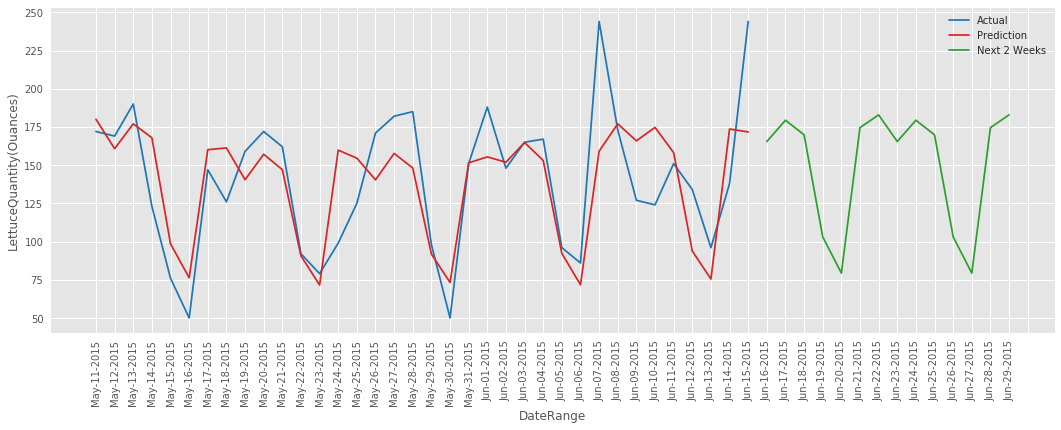

In [37]:
new_two_weeks_preds = []

history = [x for x in X]
for t in range(14):
    model = ExponentialSmoothing(np.array(history), trend=best_params[0], damped=best_params[1], seasonal=best_params[2], seasonal_periods=best_params[3])
    model_fit = model.fit(optimized=True, use_boxcox=best_params[4], remove_bias=best_params[5]) ## Set best params here
    output = model_fit.forecast()
    yhat = output[0]
    new_two_weeks_preds.append(yhat)
    history.append(yhat)
ticks = pd.date_range(final_df.index[size:len(X)][0], final_df.index[size:len(X)][-1]).tolist()
next_two_weeks_ticks = pd.date_range(start = ticks[-1], periods=15).tolist()

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(18,6))
    plt.plot(test, color='tab:blue', label='Actual')
    plt.plot(best_preds, color='tab:red', label='Prediction')
    plt.plot(range(len(best_preds), len(best_preds)+14), new_two_weeks_preds, color='tab:green', label='Next 2 Weeks')
    plt.xticks(range(len(ticks+next_two_weeks_ticks)),[t.strftime('%b-%d-%Y') for t in ticks+next_two_weeks_ticks[1:]], rotation='vertical')
    plt.ylabel('LettuceQuantity(Ouances)')
    plt.xlabel('DateRange')
    plt.legend(loc='best')

In [38]:
holtwinters_predictions = pd.DataFrame({
                                        'Store': next_two_weeks_ticks[1:], 
                                        'California 1 (ID:46673)': new_two_weeks_preds,
                                        'California 2 (ID:4904)': [0]*14,
                                        'New York 1 (ID:12631)': [0]*14,
                                        'New York 2 (ID:20974)': [0]*14
                                        })
holtwinters_predictions

,Store,California 1 (ID:46673),California 2 (ID:4904),New York 1 (ID:12631),New York 2 (ID:20974)
0,2015-06-16,165.452738,0,0,0
1,2015-06-17,179.383397,0,0,0
2,2015-06-18,169.832268,0,0,0
3,2015-06-19,103.084115,0,0,0
4,2015-06-20,79.343879,0,0,0
5,2015-06-21,174.547743,0,0,0
6,2015-06-22,182.879135,0,0,0
7,2015-06-23,165.452692,0,0,0
8,2015-06-24,179.383290,0,0,0
9,2015-06-25,169.832240,0,0,0


In [39]:
holtwinters_predictions.to_csv('holtwinters_preds.csv', index=False)
FileLink('holtwinters_preds.csv')

/kaggle/working/holtwinters_preds.csv